In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group #35</center>

## Track

(M1.1) is a *Support Vector Classifier (SVC)* with the *hinge* loss.

(A1.1.1) is an algorithm of the class of *proximal bundle methods* [[1]](#ref-1) for solving the SVC in its *primal* formulation.

(A1.1.2) is the *Sequential Minimal Optimization (SMO)* algorithm [[2]](#ref-2) (see [[3]](#ref-3) for improvements), an ad hoc *active set* method for training a SVC in its *Wolfe dual* formulation with *linear*, *polynomial* and *gaussian* kernels.

(A1.1.3) is the *AdaGrad* algorithm [[4]](#ref-4), a *deflected subgradient* method for solving the SVC in its *Lagrangian dual* formulation with *linear*, *polynomial* and *gaussian* kernels.

(M1.2) is a *Support Vector Classifier (SVC)* with the *squared hinge* loss.

(A1.2.1) is standard *gradient descent* approach for solving the SVC in its *primal* formulation.

(M2.1) is a *Support Vector Regression (SVR)* with the *epsilon-insensitive* loss.

(A2.1.1) is an algorithm of the class of *proximal bundle methods* [[1]](#ref-1) for solving the SVR in its *primal* formulation.

(A2.1.2) is the *Sequential Minimal Optimization (SMO)* algorithm [[5]](#ref-5) (see [[6]](#ref-6) for improvements), an ad hoc *active set* method for training a SVR in its *Wolfe dual* formulation with *linear*, *polynomial* and *gaussian* kernels.

(A2.1.3) is the *AdaGrad* algorithm [[4]](#ref-4), a *deflected subgradient* method for solving the SVR in its *Lagrangian dual* formulation with *linear*, *polynomial* and *gaussian* kernels.

(M2.2) is a *Support Vector Regression (SVR)* with the *squared epsilon-insensitive* loss.

(A2.2.1) is a standard *gradient descent* approach for solving the SVR in its *primal* formulation.

## Abstract

The aim of this report is to compare the *primal*, the *Wolfe dual* and the *Lagrangian dual* formulations of a learning model known as *Support Vector Machine* in terms of *numerical precision*, *time*, *accuracy* and *complexity*, i.e., the *number of support vectors*.

Firstly, I will provide a detailed mathematical derivation of the SVM model for the *classification* and the *regression* problem for all the possible formulation, then, for each of them, I will describe an algorithm to solve the optimization problem that arises from the formulation of the problem.

Finally, I will show some experiments for *linearly* and *non-linearly* separable generated datasets to compare the performace of different *kernels*, also by comparing the custom results with *sklearn* SVM implementation and *cvxopt* QP solver.

## Support Vector Machines

A *support vector machine* is a learning model used both for *classification* and *regression* tasks whose goal is to constructs a *maximum margin separator*, a decision boundary with the largest distance from the nearest training data points.

### Linear Support Vector Classifier

Given $n$ training points, where each input $x_i$ has $m$ attributes, i.e., is of dimensionality $m$, and is in one of two classes $y_i=\pm1$, i.e., our training data is of the form:

$$
\{x_i,y_i\} \ \text{where} \ i=1, \dots, n, x_i\in\Re^{m}, y_i=\pm1
$$

For simplicity we first assume that data are (not fully) linearly separable in the input space $x$, meaning that we can draw a line separating the two classes when $m=2$, a plane for $m=3$ and, more in general, a hyperplane for an arbitrary $m$.

Support vectors are the examples closest to the separating hyperplane and the aim of support vector machines is to orientate this hyperplane in such a way as to be as far as possible from the closest members of both classes, i.e., we need to maximize this margin.

This hyperplane is represented by the equation $w^T \phi(x) + b=0$, where $\phi(\cdot)$ is the identity function. So, we need to find $w$ and $b$ so that our training data can be described by:

$$
\begin{equation}
    w^T \phi(x_i) + b\geq+1-\xi_i \ \text{for} \ y_i=+1 \tag{1.1}
\end{equation}
$$
$$
\begin{equation}
    w^T \phi(x_i) + b\leq-1+\xi_i \ \text{for} \ y_i=-1 \tag{1.2}
\end{equation}
$$ 

$$\xi_i\geq 0 \ \forall_i$$

where the positive slack variables $\xi_i$ are introduced to allow missclassified points. In this way data points on the incorrect side of the margin boundary will have a penalty that increases with the distance from it.

These two equations can be combined into:

$$
\begin{equation}
    y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i \ \forall_i \tag{1.3}
\end{equation}
$$

$$\xi_i\geq 0 \ \forall_i$$

The margin is equal to $\displaystyle \frac{1}{\Vert w\Vert}$ and maximizing it subject to the constraint in (1.3) while as we are trying to reduce the number of misclassifications is equivalent to finding:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi} \quad & \Vert w \Vert + C \sum_{i=1}^{n} \xi_i \\
            \textrm{subject to} \quad & y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i \ \forall_i \\ & \xi_i \geq 0 \ \forall_i
    \end{aligned} \tag{1.4}
\end{equation}
$$

Minimizing $\Vert w\Vert$ is equivalent to minimizing $\displaystyle \frac{1}{2}\Vert w\Vert^{2}$, but in this form we will deal with a convex optimization problem that has more desirable convergence properties. So we need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi} \quad & \frac{1}{2} \Vert w \Vert^2 + C \sum_{i=1}^{n} \xi_i \\
            \textrm{subject to} \quad & y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i \ \forall_i \\ & \xi_i \geq 0 \ \forall_i
    \end{aligned} \tag{1.5}
\end{equation}
$$

where the parameter $C$ controls the trade-off between the slack variable penalty and the size of the margin.

This quadratic optimization problem can be equivalently formulated as: 

$$
\begin{equation}
    \min_{w,b} \frac{1}{2} \Vert w \Vert^2 + C \sum_{i=1}^n \max(0, 1 - y_i (w^T \phi(x_i) + b)) \tag{1.6}
\end{equation}
$$

where we make use of the *hinge* (L1) loss defined as:

$$
\mathcal{L_1} = 
\begin{cases}
0 & \text{if } y (w^T \phi(x) + b) \geq 1 \\
1 - y (w^T \phi(x) + b) & \text{otherwise} \\
\end{cases} \tag{1.7a}
$$

or, alternatively:

$$
\mathcal{L_1} = \max(0, 1 - y (w^T \phi(x) + b)) \tag{1.7b}
$$


The *hinge* loss is a convex function and it is nondifferentiable due to its nonsmoothness in 1, but has a subgradient wrt $w$ that is given by:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{L_1}}{\partial w}=
        \begin{cases}
            -y \phi(x) & \text{if } y (w^T \phi(x) + b) < 1 \\
            0 & \text{otherwise} \\ 
        \end{cases}\tag{1.8}
\end{equation}
$$

To simplify the notation and so also the algorithms the bias term $b$ is handled by augmenting the vector $w$ and each instance $x_i$ with an additional dimension:

$$
w^T = [w^T, b] \\
x_i^T = [x_i^T, 1]
$$

So, we can rewrite the (1.6) as follows:

$$
\begin{equation}
    \min_{w} \frac{1}{2} \Vert w \Vert^2 + C \sum_{i=1}^n \max(0, 1 - y_i (w^T \phi(x_i))) \tag{1.9}
\end{equation}
$$

Please notice that in terms of numerical optimization the formulation (1.6) is not equivalent to the (1.9) since in the first one the bias term $b$ does not contribute to the regularization term; but in machine learning sense, numerical experiments in [[7]](#ref-7) show that the accuracy does not vary much when the bias term $b$ is embedded into the weight vector $w$.

In [5]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge, squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.line_search import SteepestGradientDescent
from optiml.opti.unconstrained import ProximalBundle
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SKLinearSVC
from sklearn.model_selection import train_test_split

iter	 cost		 dnorm
   0	 1.3173e+01	 1.1351e+01
  20	 9.7041e-01	 1.0731e-01
  40	 8.9998e-01	 1.0083e-02
  60	 8.9861e-01	 1.4905e-08

CPU times: user 543 ms, sys: 6.01 ms, total: 549 ms
Wall time: 545 ms


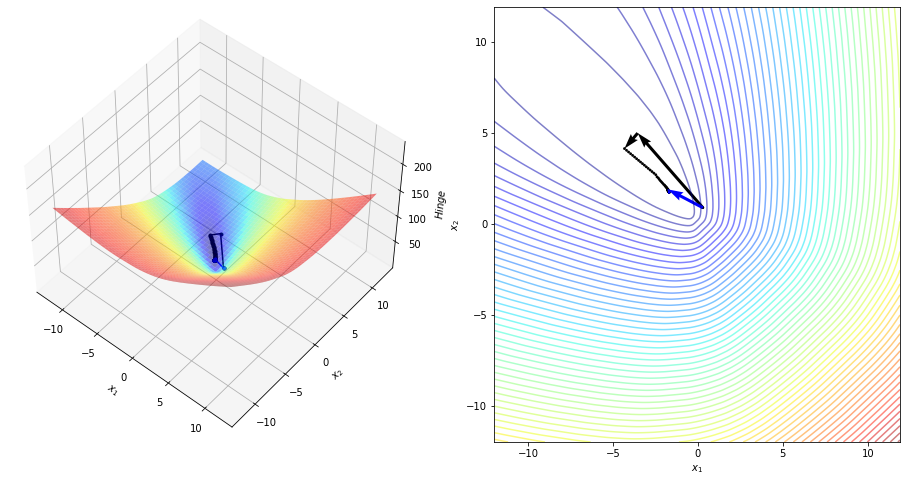

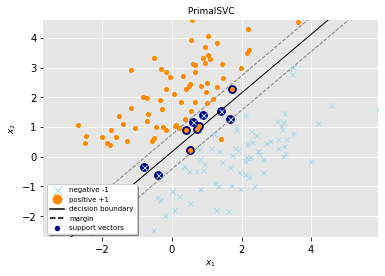

svc accuracy score is 0.98
svc found 11 support vectors from 150 examples
svc w is [-1.69814673  1.71924931]
svc b is -0.2929070402390871

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 1.33 ms


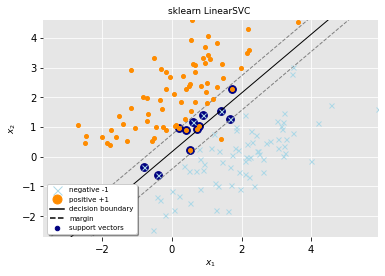

sklearn svc accuracy score is 0.98
sklearn svc found 12 support vectors from 150 examples
sklearn svc w is [[-1.69816435  1.71927417]]
sklearn svc b is [-0.29292721]


In [6]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=hinge, optimizer=ProximalBundle, C=10, mu=1, master_solver='ecos', verbose=20)
%time svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, x_min=-12, x_max=12, y_min=-12, y_max=12)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='hinge', C=10)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

Since smoothed versions of objective functions may be preferred for optimization, we can reformulate the (1.9) as:

$$
\begin{equation}
    \min_{w} \frac{1}{2} \Vert w \Vert^2 + C \sum_{i=1}^n \max(0, 1 - y_i (w^T \phi(x_i)))^2 \tag{1.10}
\end{equation}
$$

where we make use of the *squared hinge* (L2) loss.

iter	feval	 cost		 gnorm
   0	   1	 5.1742e+01	 2.7889e+01	ls:  1	it: 11	astar:  1.7748e-01
   1	  13	 4.5869e+01	 1.3574e+01	ls:  1	it:  2	astar:  2.3034e-01
   2	  16	 3.5921e+00	 2.5853e+00	ls:  1	it:  1	astar:  2.3085e-01
   3	  18	 2.4495e+00	 2.4624e-01	ls:  1	it: 14983	astar:  4.5552e-01
   4	15001	 2.4857e+00	 2.7360e-01

CPU times: user 1.05 s, sys: 4.35 ms, total: 1.05 s
Wall time: 1.05 s


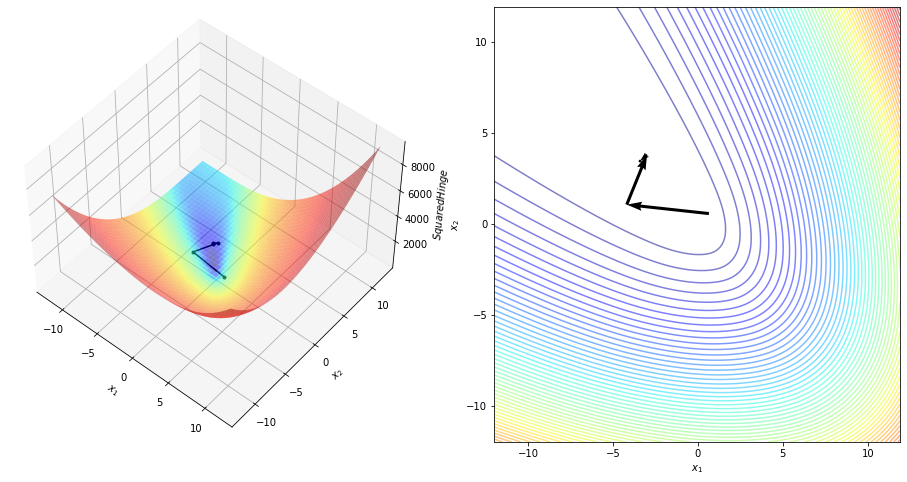

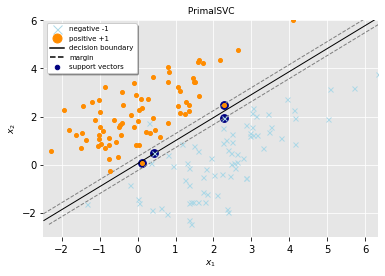

svc accuracy score is 1.0
svc found 4 support vectors from 150 examples
svc w is [-3.29722695  3.44888748]
svc b is -0.14152496628811195

CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.3 ms


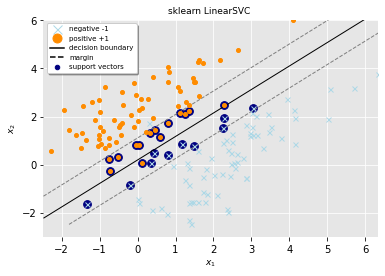

sklearn svc accuracy score is 1.0
sklearn svc found 24 support vectors from 150 examples
sklearn svc w is [[-1.06651609  1.09355149]]
sklearn svc b is [-0.21285303]


In [7]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=squared_hinge, optimizer=SteepestGradientDescent, C=10, verbose=True)
%time svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, x_min=-12, x_max=12, y_min=-12, y_max=12)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='squared_hinge', C=10)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

To reformulate the (1.5) as a *Wolfe dual*, we need to allocate the Lagrange multipliers $\alpha_i\geq 0, \mu_i \geq 0 \ \forall_i$:

$$
\begin{equation}
    \max_{\alpha,\mu} \min_{w,b,\xi} \mathcal{W}(w,b,\xi,\alpha,\mu) \displaystyle = \frac{1}{2}\Vert w\Vert^{2}+C\sum_{i=1}^n\xi_i-\sum_{i=1}^n\alpha_i(y_i(w^T \phi(x_i) + b)-1+\xi_i)-\sum_{i=1}^n\mu_i\xi_i \tag{1.11}
\end{equation}
$$

We wish to find the $w$, $b$ and $\xi_i$ which minimizes, and the $\alpha$ and $\mu$ which maximizes $\mathcal{W}$, provided $\alpha_i\geq 0, \mu_i \geq 0 \ \forall_i$. We can do this by differentiating $\mathcal{W}$ wrt $w$ and $b$ and setting the derivatives to 0:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=w-\sum_{i=1}^{n}\alpha_i y_i x_i\Rightarrow w=\sum_{i=1}^{n}\alpha_i y_i x_i \tag{1.12}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=-\sum_{i=1}^{n}\alpha_i y_i\Rightarrow\sum_{i=1}^{n}\alpha_i y_i=0 \tag{1.13}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_i}=0\Rightarrow C=\alpha_i+\mu_i \tag{1.14}
\end{equation}
$$

Substituting (1.12) and (1.13) into (1.11) together with $\mu_i\geq 0 \ \forall_i$, which implies that $\alpha\leq C$, gives a new formulation being dependent on $\alpha$. We therefore need to find:

$$
\begin{align*}
    \max_{\alpha} \mathcal{W}(\alpha) \displaystyle &= \sum_{i=1}^{n}\alpha_i - \frac{1}{2}\sum_{i,j}\alpha_i\alpha_j y_i y_j \langle x_i, x_j \rangle \\
    &= \displaystyle \sum_{i=1}^{n}\alpha_i - \frac{1}{2}\sum_{i,j}\alpha_i Q_{ij}\alpha_j \ \text{where} \ Q_{ij} = y_i y_j \langle x_i, x_j \rangle \\
    &= \sum_{i=1}^{n}\alpha_i - \frac{1}{2}\alpha^T Q\alpha \ \text{subject to} \ 0\leq\alpha_i\leq C \ \forall_i, \displaystyle \sum_{i=1}^{n}\alpha_i y_i=0 \tag{1.15}
\end{align*}
$$

Having moved from minimizing $\mathcal{W}(w,b,\xi)$ to maximizing $\mathcal{W}(\alpha)$, we need to minimize:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2}\alpha^T Q\alpha+q^T\alpha \\
            \textrm{subject to} \quad & 0\leq\alpha_i\leq C \ \forall_i \\ & y^T\alpha=0
    \end{aligned} \tag{1.16}
\end{equation}
$$

where $q^T = [1, \dots, 1]$.

By solving (1.16) we will know $\alpha$ and, from (1.12), we will get $w$, so we need to calculate $b.$

We know that any data point satisfying (1.13) which is a support vector $x_s$ will have the form:

$$y_s(w^T \phi(x_s) + b)=1 \tag{1.17}$$

and, by substituting in (1.12), we get:

$$y_s\big(\sum_{m\in S}\alpha_m y_m \langle x_m, x_s \rangle +b\big)=1 \tag{1.18}$$

where $s$ denotes the set of indices of the support vectors and is determined by finding the indices $i$ where $\alpha_i>0$, i.e., nonzero Lagrange multipliers.

Multiplying through by $y_s$ and then using $y_s^2=1$ from (1.1) and (1.2):

$$y_s^2\big(\sum_{m\in S}\alpha_m y_m \langle x_m, x_s \rangle +b\big)=y_s \tag{1.19}$$
$$b=y_s-\sum_{m\in S}\alpha_m y_m \langle x_m, x_s \rangle \tag{1.20}$$

Instead of using an arbitrary support vector $x_s$, it is better to take an average over all of the support vectors in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_s}\sum_{s\in S} y_s-\sum_{m\in S}\alpha_m y_m \langle x_m, x_s \rangle \tag{1.21}
\end{equation}
$$

We now have the variables $w$ and $b$ that define our separating hyperplane's optimal orientation and hence our support vector machine. Each new point $x'$ is classified by evaluating:

$$
\begin{equation}
    y'=\displaystyle \operatorname{sgn}\big(\sum_{i=1}^{n}\alpha_i y_i\langle x_i, x' \rangle+b\big) \tag{1.22}
\end{equation}
$$

The minimization problem (1.16) can be solved using common quadratic programming methods. However, it can be computationally expensive to use QP algorithms, especially since the gram matrix $Q$ may be too large to be stored in memory. Using a *decomposition method* instead can speed up the computation and avoid running out of memory.

*Decomposition methods* (also called *chunking* and *working set* methods) separate all observations into two disjoint sets: the working set and the remaining set. A decomposition method modifies only the elements in the working set in each iteration. Therefore, only some columns of the gram matrix are needed in each iteration, which reduces the amount of storage needed for each iteration.

The *Sequential Minimal Optimization* (SMO) [[1]](#ref-1) method is the most popular approach for solving SVM problems. SMO performs a series of two-point optimizations since we have only one equality constraint $y^T \alpha=0$. At each iteration, a working set of two points are chosen based on a selection rule that uses second-order information. Then the Lagrange multipliers for this working set are solved analytically as follows: first, we initialize $\alpha = 0$, which is a feasible point, since we have $\alpha_i\geq 0$ and $y^T \alpha=0$. At each iteration, a working set ${\alpha_i, \alpha_j}$ is selected and the quadratic objective function is minimized along the line $y^T \alpha=0$. Then, the new values for $\alpha_i$ and $\alpha_j$ are clipped to be $\geq 0$ in order to meet the inequality constraint as well.
    
Since the KKT conditions are sufficient for optimality, $\alpha$ is optimal as soon as the conditions are satisfied. In practice, one usually tests whether the largest KKT violation falls below some predefined threshold. If so, the method stops; otherwise, the next iteration starts.

Since the SMO method is designed to deal the equality constraint explicitly we will make use of the formulation (1.16) but, for completeness reasons, we report below the box-constrained dual formulation [[7]](#ref-7) that arises from the primal (1.9) where the bias term $b$ is embedded into the weight vector $w$:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2} \alpha^T (Q + yy^T)\alpha+q^T\alpha \\
            \textrm{subject to} \quad & 0\leq\alpha_i\leq C \ \forall_i
    \end{aligned} \tag{1.23}
\end{equation}
$$

In [8]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-6.4559e+00
   1	-1.4403e+01
   2	-1.7765e+01
   3	-1.8042e+01
   4	-1.8142e+01
   5	-1.8238e+01
   6	-1.8329e+01
   7	-1.8416e+01
   8	-1.8484e+01
   9	-1.8621e+01
  10	-1.8621e+01
  11	-1.8621e+01
  12	-1.8621e+01
  13	-1.8621e+01

CPU times: user 323 ms, sys: 177 ms, total: 501 ms
Wall time: 101 ms


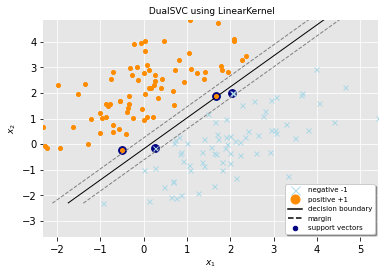

svc accuracy score is 0.98
svc found 4 support vectors from 150 examples
svc w is [-2.80910719  2.31478658]
svc b is 0.43732067963345056

     pcost       dcost       gap    pres   dres
 0: -1.2735e+02 -1.0234e+04  3e+04  8e-01  5e-14
 1: -2.3936e+01 -2.5024e+03  4e+03  7e-02  5e-14
 2:  2.7095e+01 -3.5331e+02  5e+02  9e-03  3e-14
 3:  4.2541e+00 -7.4239e+01  9e+01  1e-03  2e-14
 4: -1.0230e+01 -2.9169e+01  2e+01  2e-15  2e-14
 5: -1.5173e+01 -2.1697e+01  7e+00  5e-15  1e-14
 6: -1.7002e+01 -2.0971e+01  4e+00  3e-15  1e-14
 7: -1.8535e+01 -1.8730e+01  2e-01  3e-15  1e-14
 8: -1.8621e+01 -1.8623e+01  2e-03  5e-15  1e-14
 9: -1.8621e+01 -1.8622e+01  2e-05  2e-16  2e-14
10: -1.8621e+01 -1.8621e+01  2e-07  5e-15  1e-14
Optimal solution found.

CPU times: user 253 ms, sys: 280 ms, total: 533 ms
Wall time: 78 ms


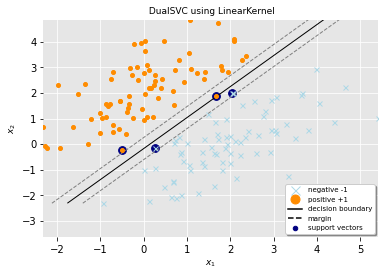

cvxopt svc accuracy score is 0.98
cvxopt svc found 4 support vectors from 150 examples
cvxopt svc w is [-2.81089099  2.31683139]
cvxopt svc b is 0.40963338212145195

CPU times: user 1.39 ms, sys: 0 ns, total: 1.39 ms
Wall time: 1.24 ms


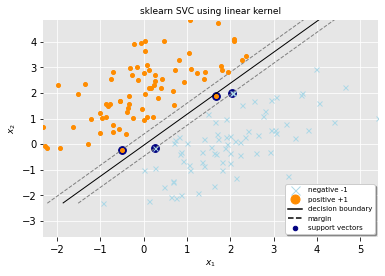

sklearn svc accuracy score is 0.98
sklearn svc found 4 support vectors from 150 examples
sklearn svc w is [[-2.8099558   2.31605983]]
sklearn svc b is [0.10980872]


In [24]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=10, optimizer=SMOClassifier, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=linear, C=10, optimizer='cvxopt', verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
print(f'cvxopt svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svc w is {svc.coef_}')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SklSVC(kernel='linear', C=10)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In order to relax the constraints in the *Wolfe dual* formulation (1.16) we define the problem as a *Lagrangian dual* relaxation by embedding them into objective function, so we need to allocate the Lagrangian multipliers $\mu \geq 0, \lambda_+ \geq 0$, $\lambda_- \geq 0$:

$$
\begin{align*}
    \max_{\mu,\lambda_+,\lambda_-} \min_{\alpha} \mathcal{L}(\alpha,\mu,\lambda_+,\lambda_-) &= \frac{1}{2} \alpha^T Q\alpha+q^T\alpha - \mu^T (y^T \alpha) - \lambda_+^T (ub - \alpha) - \lambda_-^T \alpha \\
    &= \displaystyle \frac{1}{2} \alpha^T Q\alpha + (q - \mu y + \lambda_+ - \lambda_-)^T \alpha - \lambda_+^T ub \tag{1.24}
\end{align*}
$$

where the upper bound $ub^T = [C, \dots, C]$.

Taking the derivative of the Lagrangian $\mathcal{L}$ wrt $\alpha$ and settings it to 0 gives:

$$
\begin{align*}
    \displaystyle \frac{\partial \mathcal{L}}{\partial \alpha}=0\Rightarrow Q \alpha + (q - \mu y + \lambda_+ - \lambda_-) = 0 \tag{1.25}
\end{align*}
$$

With $\alpha$ optimal solution of the linear system:

$$
\begin{align*}
    Q \alpha = - (q - \mu y + \lambda_+ - \lambda_-) \tag{1.26}
\end{align*}
$$

the gradient wrt $\mu$, $\lambda_+$ and $\lambda_-$ are:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{L}}{\partial \mu}=-y \alpha \tag{1.29}
\end{equation}
$$

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{L}}{\partial \lambda_+}=\alpha - ub \tag{1.27}
\end{equation}
$$

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{L}}{\partial \lambda_-}=-\alpha \tag{1.28}
\end{equation}
$$

If the Hessian matrix Q is indefinite, i.e., the Lagrangian function is not strictly convex since it will be linear along the eigenvectors correspondent to the null eigenvalues, the Lagrangian dual relaxation will be nondifferentiable, so it will have infinite solutions and for each of them it will have a different subgradient. In order to compute the gradient, we will choose $\alpha^*$ in such a way as the one that minimizes the residue in the least-squares sense.

Given a decreasing learning rate, we might end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be determined. In other words, the learning rate either decreases too quickly for frequent features or too slowly for infrequent ones.

A possible hack to redress this issue would be to count the number of times we see a particular feature and to use this as a clock for adjusting learning rates. That is, rather than choosing a learning rate of the form $\displaystyle \eta = \frac{\eta_0}{\sqrt{t + c}}$ we could use $\displaystyle \eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$ where $s(i, t)$ counts the number of nonzeros for feature $i$ that we have observed up to time $t$. This is actually quite easy to implement at no meaningful overhead. However, it fails whenever we do not quite have sparsity but rather just data where the gradients are often very small and only rarely large. After all, it is unclear where one would draw the line between something that qualifies as an observed feature or not.

*AdaGrad* [[3]](#ref-3) addresses this by replacing the raw counter $s(i, t)$ by an aggregate of the squares of previously observed gradients. In particular, it uses $s(i, t+1) = s(i, t) + \left(\partial_i f(x)\right)^2$ as a means to adjust the learning rate. This has two benefits: first, we no longer need to decide just when a gradient is large enough. Second, it scales automatically with the magnitude of the gradients. Coordinates that routinely correspond to large gradients are scaled down significantly, whereas others with small gradients receive a much more gentle treatment.

We use the variable $s_t$ to accumulate past gradient variance as follows:

$$
\begin{split}
    \begin{aligned}
        g_t & = \partial_{{w_t}} \mathcal{L}(y_t, f(x_t, w)) \\
        s_t & = s_{t-1} + g_t^2 \\
        w_{t+1} & = w_t - \frac{\eta}{\sqrt{s_t + \epsilon}} \cdot g_t
    \end{aligned}
\end{split}
$$

where $\epsilon$ is an additive constant that ensures that we do not divide by 0. 

In [4]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.7133e+01	pcost:  4.5118e+02	gap:  1.0380e+00	itn:   2	rnorm: 9.6668e-11
 100	 100	 1.6276e+01	pcost:  2.7886e+02	gap:  9.4164e-01	itn:   2	rnorm: 1.0880e-10
 200	 200	 1.4105e+01	pcost:  2.7886e+02	gap:  9.4942e-01	itn:   2	rnorm: 1.1035e-10
 300	 300	 1.7274e+01	pcost:  2.7679e+02	gap:  9.3759e-01	itn:   2	rnorm: 1.4897e-10
 400	 400	 1.4716e+01	pcost:  2.7679e+02	gap:  9.4683e-01	itn:   2	rnorm: 1.5960e-10
 500	 500	 1.6416e+01	pcost:  2.7497e+02	gap:  9.4030e-01	itn:   2	rnorm: 2.2136e-10
 600	 600	 1.3617e+01	pcost:  2.5075e+02	gap:  9.4569e-01	itn:   2	rnorm: 5.6609e-11
 700	 700	 1.6730e+01	pcost:  2.5075e+02	gap:  9.3328e-01	itn:   2	rnorm: 2.4570e-10
 800	 800	 1.5265e+01	pcost:  2.5075e+02	gap:  9.3912e-01	itn:   2	rnorm: 6.4323e-11
 900	 900	 1.5620e+01	pcost:  2.3627e+02	gap:  9.3389e-01	itn:   2	rnorm: 3.4188e-10

CPU times: user 9.36 s, sys: 8.12 s, total: 17.5 s
Wall time: 2.42 s


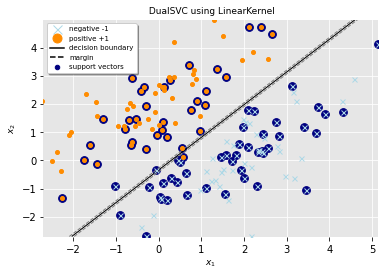

svc accuracy score is 0.96
svc found 78 support vectors from 150 examples
svc w is [-17.28815621  14.91733794]
svc b is 5.052642514523931


In [7]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=10, optimizer=AdaGrad, use_explicit_eq=True, 
              nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=100)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

From (1.16) we can notice that the equality constraint $y^T \alpha = 0$ arises form the stationarity condition $\partial_{{b}} \mathcal{W}=0$. So, again, for simplicity, we can again consider the bias term $b$ embedded into the weight vector. In this way the dimensionality of (1.24) is reduced of 1/3 by removing the multipliers $\mu$ which was allocated to control the equality constraint $y^T \alpha=0$, so we will end up solving exactly the problem (1.23).

$$
\begin{align*}
    \max_{\lambda_+,\lambda_-} \min_{\alpha} \mathcal{L}(\alpha,\lambda_+,\lambda_-) &= \frac{1}{2} \alpha^T (Q + yy^T)\alpha+q^T\alpha - \lambda_+^T (ub - \alpha) - \lambda_-^T \alpha \\
    &= \displaystyle \frac{1}{2} \alpha^T (Q + yy^T)\alpha + (q + \lambda_+ - \lambda_-)^T \alpha - \lambda_+^T ub \tag{1.30}
\end{align*}
$$

epoch	iter	 cost	
   0	   0	-1.1994e+01	pcost:  4.2306e+02	gap:  1.0284e+00	itn:   3	rnorm: 5.6244e-09
 100	 100	-1.3870e+01	pcost:  3.3548e+02	gap:  1.0413e+00	itn:   3	rnorm: 8.5922e-09
 200	 200	-1.5980e+01	pcost:  3.1744e+02	gap:  1.0503e+00	itn:   3	rnorm: 1.6319e-09
 300	 300	-1.1685e+01	pcost:  3.1744e+02	gap:  1.0368e+00	itn:   3	rnorm: 5.8123e-09
 400	 400	-1.3396e+01	pcost:  3.1744e+02	gap:  1.0422e+00	itn:   3	rnorm: 2.5131e-09
 500	 500	-1.6382e+01	pcost:  3.1067e+02	gap:  1.0527e+00	itn:   3	rnorm: 6.0962e-09
 600	 600	-1.3940e+01	pcost:  3.1067e+02	gap:  1.0449e+00	itn:   3	rnorm: 6.3908e-09
 700	 700	-1.1753e+01	pcost:  3.1067e+02	gap:  1.0378e+00	itn:   3	rnorm: 1.6658e-09
 800	 800	-1.2873e+01	pcost:  2.9424e+02	gap:  1.0437e+00	itn:   3	rnorm: 8.9032e-09
 900	 900	-1.4700e+01	pcost:  2.9424e+02	gap:  1.0500e+00	itn:   3	rnorm: 2.9039e-09

CPU times: user 8.93 s, sys: 7.5 s, total: 16.4 s
Wall time: 2.25 s


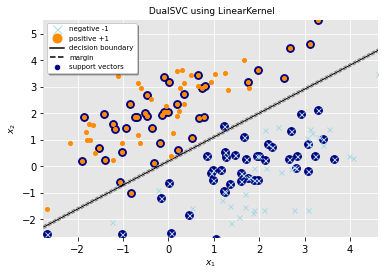

svc accuracy score is 1.0
svc found 83 support vectors from 150 examples
svc w is [-16.87570397  18.65043857]
svc b is -3.5908608233881774


In [8]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=10, optimizer=AdaGrad, use_explicit_eq=False, 
              nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=100)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

### Linear Support Vector Regression

In the case of regression the goal is to predict a real-valued output for $y'$ so that our training data is of the form:

$$
\{x_i,y_i\} \text{where i}=1, \dots, n, x\in\Re^{m}, y_i\in\Re
$$

The regression SVM use a loss function that not allocating a penalty if the predicted value $y'_i$ is less than a distance $\epsilon$ away from the actual value $y_i$, i.e., if $|y_i-y'_i| \leq \epsilon$, where $y'_i = w^T \phi(x_i) + b$ and $\phi(\cdot)$ is the identity function. This is formally described by:

$$
\mathcal{L_\epsilon} = 
\begin{cases}
0 & \text{if } |y - (w^T \phi(x_i) + b)| \leq \epsilon \\
|y - (w^T \phi(x_i) + b)| - \epsilon & \text{otherwise} \\
\end{cases} \tag{2.1a}
$$

or, alternatively:

$$
\mathcal{L_\epsilon} = \max(0, |y - (w^T \phi(x_i) + b)| - \epsilon) \tag{2.1b}
$$

As the *hinge* loss, also the *epsilon insensitive* loss is a convex function and it is not differentiable due to its non-smoothness in $\pm\epsilon$, but has a subgradient wrt $w$ that is given by:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{L_\epsilon}}{\partial w}=
        \begin{cases}
            (y - (w^T \phi(x_i) + b)) x & \text{if } |y - (w^T \phi(x_i) + b)| > \epsilon \\
            0 & \text{otherwise} \\ 
        \end{cases} \tag{2.2}
\end{equation}
$$

The region bound by $y'_i\pm\epsilon \ \forall_i$ is called an $\epsilon$-insensitive tube. The output variables which are outside the tube are given one of two slack variable penalties depending on whether they lie above, $\xi^+$, or below, $\xi^-$, the tube, provided $\xi^+ \geq 0$ and $\xi^- \geq 0 \ \forall_i$:

$$
\begin{equation}
    y_i\leq y'_i+\epsilon+\xi^+ \tag{2.3}
\end{equation}
$$
$$
\begin{equation}
    y_i\geq y'_i-\epsilon-\xi^- \tag{2.4}
\end{equation}
$$

The error function for SVM regression can then be written as:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi^+,\xi^-} \quad & \frac{1}{2}\Vert w\Vert^{2} + C \sum_{i=1}^{n}(\xi_i^+ + \xi_i^-) \\
            \textrm{subject to} \quad & y_i - w^T \phi(x_i) - b \leq \epsilon + \xi_i^+ \ \forall_i \\ & w^T \phi(x_i) + b - y_i \leq \epsilon + \xi_i^- \ \forall_i \\ & \xi_i^+, \xi_i^- \geq 0 \ \forall_i
    \end{aligned} \tag{2.5}
\end{equation}
$$

This optimization problem can be formulated with the bias term $b$ embedded into the weight vector $w$ as:

$$
\begin{equation}
    \min_ {w} \frac{1}{2} \Vert w\Vert^{2} + C \sum_{i=1}^n \max(0, |y_i - w^T \phi(x_i)| - \epsilon) \tag{2.6}
\end{equation}
$$

where we make use of the *epsilon-insensitive* (L1) loss.

In [28]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive, squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.line_search import SteepestGradientDescent
from optiml.opti.unconstrained import ProximalBundle
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVR as SKLinearSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

iter	 cost		 dnorm
   0	 5.3282e+01	 7.2604e+01
 150	 2.8471e+01	 5.4509e+00
 300	 2.8471e+01	 5.4509e+00
 450	 2.8471e+01	 5.4509e+00
 600	 2.8471e+01	 5.4509e+00
 750	 2.8471e+01	 5.4509e+00
 900	 2.8471e+01	 5.4509e+00
1050	 2.8471e+01	 5.4509e+00
1200	 2.8471e+01	 5.4509e+00
1350	 2.8471e+01	 5.4509e+00
1500	 2.8471e+01	 5.4509e+00
1650	 2.8471e+01	 5.4509e+00
1800	 2.8471e+01	 5.4509e+00
1950	 2.8471e+01	 5.4509e+00

CPU times: user 43.4 s, sys: 14.3 ms, total: 43.4 s
Wall time: 43.4 s


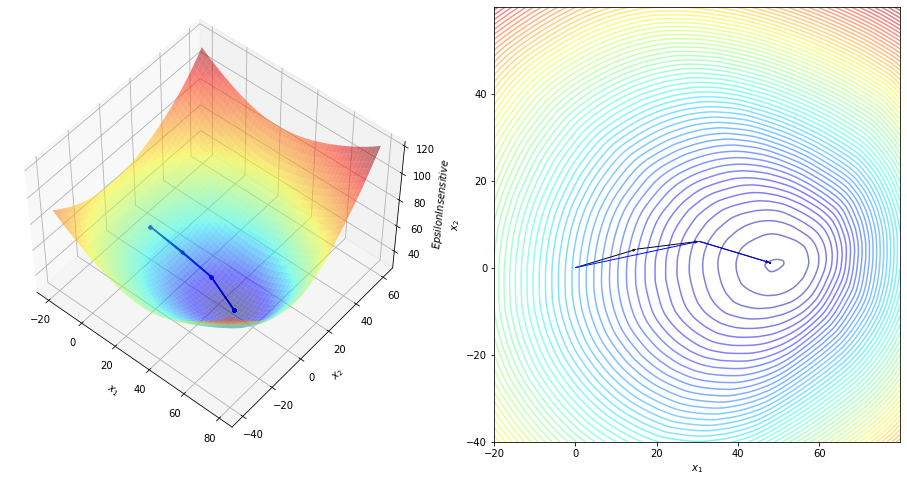

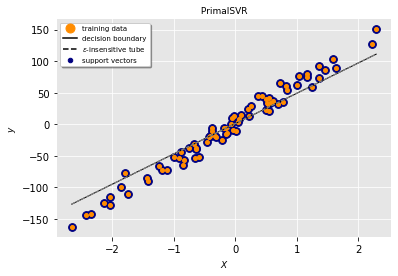

svr r2 score is 0.9486918354880973
svr found 74 support vectors from 75 examples
svr w is [47.94836262]
svr b is 1.1789647857309848

CPU times: user 580 µs, sys: 46 µs, total: 626 µs
Wall time: 377 µs


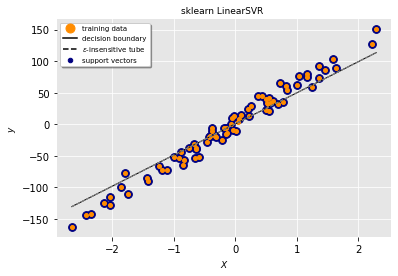

sklearn svr r2 score is 0.9542623441716609
sklearn svr found 74 support vectors from 75 examples
sklearn svr w is [49.23946363]
sklearn svr b is [0.62803816]


In [30]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = PrimalSVR(loss=epsilon_insensitive, epsilon=0.1, C=10, optimizer=ProximalBundle, 
                max_iter=2000, mu=1, master_solver='ecos', verbose=150)
%time svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, x_min=-20, x_max=80, y_min=-40, y_max=60)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLinearSVR(loss='epsilon_insensitive', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

To provide a continuously differentiable function the optimization problem (2.6) can be formulated as: 

$$
\begin{equation}
    \min_ {w} \frac{1}{2} \Vert w\Vert^{2} + C \sum_{i=1}^n \max(0, |y_i - w^T \phi(x_i)| - \epsilon)^2 \tag{2.7}
\end{equation}
$$

where we make use of the *squared epsilon-insensitive* (L2) loss.

iter	feval	 cost		 gnorm
   0	   1	 3.5616e+04	 1.2014e+03	ls:  1	it:  1	astar:  4.7324e-02
   1	   3	 1.5359e+03	 1.5819e+02	ls:  1	it:  1	astar:  5.1479e-02
   2	   5	 8.9685e+02	 2.2657e+01	ls:  1	it:  1	astar:  4.7324e-02
   3	   7	 8.8499e+02	 2.9833e+00	ls:  1	it:  1	astar:  5.1479e-02
   4	   9	 8.8477e+02	 4.2729e-01	ls:  1	it:  2	astar:  4.7324e-02
   5	  11	 8.8477e+02	 5.6261e-02	ls:  1	it:  8	astar:  5.1479e-02
   6	  19	 8.8477e+02	 8.0582e-03	ls:  1	it:  7	astar:  4.7324e-02
   7	  26	 8.8477e+02	 1.0610e-03	ls:  1	it:  6	astar:  5.1479e-02
   8	  32	 8.8477e+02	 1.5197e-04	ls:  1	it:  2	astar:  4.7324e-02
   9	  34	 8.8477e+02	 2.0009e-05	ls:  1	it:  4	astar:  5.1574e-02
  10	  38	 8.8477e+02	 2.8714e-06	ls:  1	it:  2	astar:  4.7165e-02
  11	  40	 8.8477e+02	 3.7372e-07

CPU times: user 12.1 ms, sys: 4.33 ms, total: 16.4 ms
Wall time: 12.8 ms


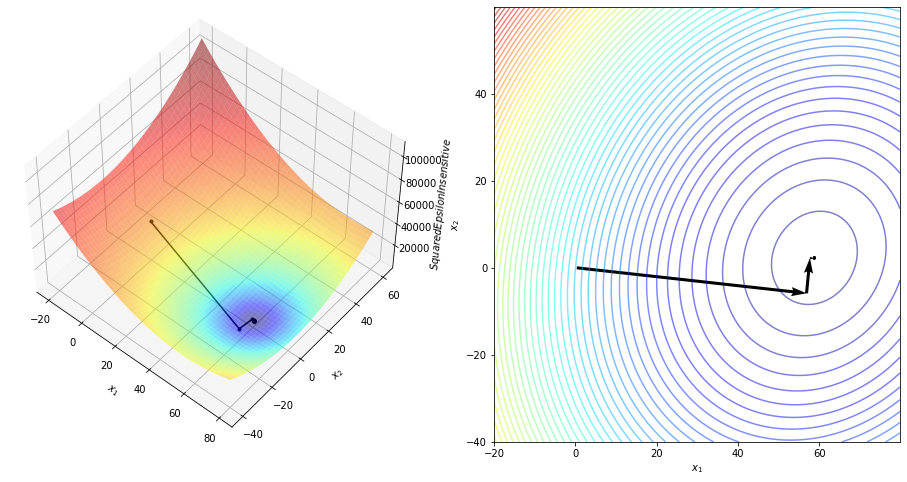

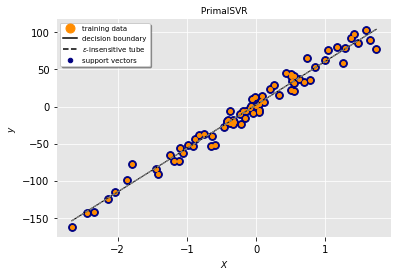

svr r2 score is 0.9815988018645927
svr found 75 support vectors from 75 examples
svr w is [58.83256051]
svr b is 2.303905473543353

CPU times: user 3.37 ms, sys: 0 ns, total: 3.37 ms
Wall time: 2.77 ms


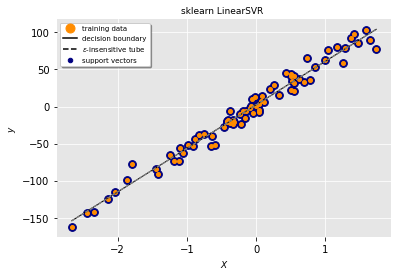

sklearn svr r2 score is 0.981583884871758
sklearn svr found 75 support vectors from 75 examples
sklearn svr w is [58.81896316]
sklearn svr b is [2.30068004]


In [31]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = PrimalSVR(loss=squared_epsilon_insensitive, epsilon=0.1, C=10, 
                optimizer=SteepestGradientDescent, verbose=True)
%time svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, x_min=-20, x_max=80, y_min=-40, y_max=60)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLinearSVR(loss='squared_epsilon_insensitive', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

To reformulate the (2.5) as a *Wolfe dual*, we introduce Lagrange multipliers $\alpha_i^+ \geq 0, \alpha_i^- \geq 0, \mu_i^+ \geq 0, \mu_i^- \geq 0 \ \forall_i$:

$$
\begin{align*}
    \max_{\alpha^+,\alpha^-,\mu^+,\mu^-} \min_{w,b,\xi^+,\xi^-} \mathcal{W}(w,b,\xi^+,\xi^-,\alpha^+,\alpha^-,\mu^+,\mu^-) \displaystyle = \frac{1}{2}\Vert w\Vert^{2}+C \sum_{i=1}^n(\xi_i^+ + \xi_i^-)-\sum_{i=1}^n(\mu_i^+ \xi_i^+ + \mu_i^- \xi_i^-) \\ -\sum_{i=1}^n\alpha_i^+(\epsilon+\xi_i^+ + y'_i-y_i)-\sum_{i=1}^n\alpha_i^-(\epsilon+\xi_i^- - y'_i+y_i) \tag{2.8}
\end{align*}
$$

Substituting for $y_i$, differentiating wrt $w, b, \xi^+$, $\xi^-$ and setting the derivatives to $0$:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=w-\sum_{i=1}^{n}(\alpha_i^+ - \alpha_i^-)x_i\Rightarrow w=\sum_{i=1}^{n}(\alpha_i^+ - \alpha_i^-)x_i \tag{2.9}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=-\sum_{i=1}^{n}(\alpha_i^+ - \alpha_i^-)\Rightarrow \sum_{i=1}^{n}(\alpha_i^+ - \alpha_i^-)=0 \tag{2.10}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_i^+}=0\Rightarrow C=\alpha_i^+ + \mu_i^+ \tag{2.11}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_i^-}=0\Rightarrow C=\alpha_i^- + \mu_i^- \tag{2.12}
\end{equation}
$$

Substituting (2.9) and (2.10) in, we now need to maximize $\mathcal{W}$ wrt $\alpha_i^+$ and $\alpha_i^-$, where $\alpha_i^+ \geq 0,\ \alpha_i^- \geq 0 \ \forall_i$:

$$
\begin{equation}
    \max_{\alpha^+,\alpha^-} \mathcal{W}(\alpha^+,\alpha^-) = \displaystyle \sum_{i=1}^{n}y_i(\alpha_i^+ - \alpha_i^-)-\epsilon\sum_{i=1}^{n}(\alpha_i^+ + \alpha_i^-)-\frac{1}{2}\sum_{i,j}(\alpha_i^+ - \alpha_i^-)\langle x_i, x_j \rangle(\alpha_j ^+ - \alpha_j ^-) \tag{2.13}
\end{equation}
$$

Using $\mu_i^+ \geq 0$ and $\mu_i^- \geq 0$ together with (2.9) and (2.10) means that $\alpha_i^+ \leq C$ and $\alpha_i^- \leq C$. We therefore need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha^+,\alpha^-} \quad & \frac{1}{2}(\alpha^+ - \alpha^-)^TK(\alpha^+ - \alpha^-)+\epsilon q^T(\alpha^+ + \alpha^-)-y^T(\alpha^+ - \alpha^-) \\
            \textrm{subject to} \quad & 0\leq\alpha_i^+,\alpha_i^- \leq C \ \forall_i \\ & q^T(\alpha^+ - \alpha^-)=0
    \end{aligned} \tag{2.14}
\end{equation}
$$

where $q^T = [1, \dots, 1]$.

We can write the (2.14) in a standard quadratic form as:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2}\alpha^T Q\alpha-q^T\alpha \\
            \textrm{subject to} \quad & 0\leq\alpha_i\leq C \ \forall_i \\ & e^T\alpha=0
    \end{aligned} \tag{2.15}
\end{equation}
$$

where the Hessian matrix $Q$ is 
$
\begin{bmatrix}
K & -K\\
-K & K 
\end{bmatrix}$
, $q$ is 
$
\begin{bmatrix}
-y\\
y
\end{bmatrix}$ + $\epsilon$
, and $e$ is 
$
\begin{bmatrix}
1\\
-1
\end{bmatrix}$.

Each new predictions $y'$ can be found using:

$$
\begin{equation}
    y'=\displaystyle \sum_{i=1}^{n}(\alpha_i^+ - \alpha_i^-)\langle x_i, x' \rangle+b \tag{2.16}
\end{equation}
$$

A set $S$ of support vectors $x_s$ can be created by finding the indices $i$ where $0\leq\alpha\leq C$ and $\xi_i^+=0$ or $\xi_i^-=0$.

This gives us:

$$
\begin{equation}
    b=y_s-\displaystyle \epsilon-\sum_{m\in S}(\alpha_m^+ -\alpha_m^-) \langle x_m, x_s \rangle \tag{2.17}
\end{equation}
$$

As before it is better to average over all the indices $i$ in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_s}\sum_{s\in S}y_s-\epsilon-\sum_{m \in S}(\alpha_m^+ - \alpha_m^-)\langle x_m, x_s \rangle \tag{2.18}
\end{equation}
$$

In [32]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

iter	 cost
   0	-6.2037e+03
   3	-6.8519e+03
   6	-6.9873e+03
   9	-7.0608e+03
  12	-7.0624e+03
  15	-7.0641e+03
  18	-7.0657e+03
  21	-7.0673e+03
  24	-7.0682e+03
  27	-7.0691e+03
  30	-7.0700e+03
  33	-7.0709e+03
  36	-7.0716e+03
  39	-7.0722e+03

CPU times: user 822 ms, sys: 354 ms, total: 1.18 s
Wall time: 191 ms


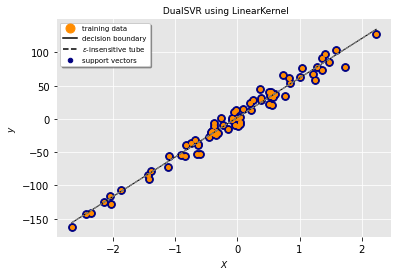

svr r2 score is 0.974828140190886
svr found 75 support vectors from 75 examples
svr w is [59.47669884]
svr b is 2.122650013728763

     pcost       dcost       gap    pres   dres
 0: -7.9071e+03 -2.2785e+04  5e+04  1e+00  5e-16
 1: -5.3712e+03 -1.2744e+04  7e+03  6e-14  4e-16
 2: -6.5430e+03 -7.4715e+03  9e+02  1e-13  3e-16
 3: -6.9645e+03 -7.1609e+03  2e+02  1e-13  3e-16
 4: -7.0471e+03 -7.0939e+03  5e+01  8e-14  3e-16
 5: -7.0698e+03 -7.0747e+03  5e+00  5e-14  3e-16
 6: -7.0722e+03 -7.0723e+03  1e-01  9e-14  3e-16
 7: -7.0723e+03 -7.0723e+03  1e-03  5e-14  3e-16
Optimal solution found.

CPU times: user 229 ms, sys: 93.9 ms, total: 323 ms
Wall time: 50.1 ms


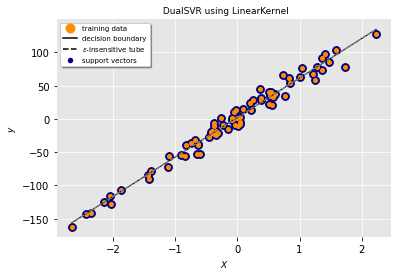

cvxopt svr r2 score is 0.9748172307112926
cvxopt svr found 75 support vectors from 75 examples
cvxopt svr w is [59.47670217]
cvxopt svr b is 2.0905802493036263

CPU times: user 1.59 ms, sys: 134 µs, total: 1.72 ms
Wall time: 1.07 ms


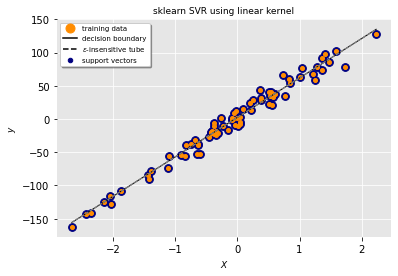

sklearn svr r2 score is 0.974902108680764
sklearn svr found 75 support vectors from 75 examples
sklearn svr w is [[59.4766987]]
sklearn svr b is [2.40525739]


In [36]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=SMORegression, verbose=3)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr w is {svr.coef_}')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='linear', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.24) is:

In [14]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.7919e+03	pcost: -1.7588e+03	gap:  1.8864e-02	itn:   1	rnorm: 3.5403e-11
   1	   1	-1.3835e+03	pcost: -1.7735e+03	gap: -2.1989e-01	itn:   1	rnorm: 3.3623e-11

CPU times: user 28.9 ms, sys: 13.7 ms, total: 42.6 ms
Wall time: 7.99 ms


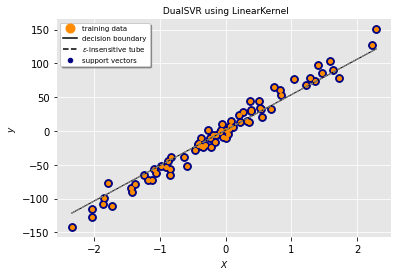

svr r2 score is 0.9642648047543028
svr found 75 support vectors from 75 examples
svr w is [52.3800502]
svr b is 1.320375025942155


In [15]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=AdaGrad, use_explicit_eq=True, 
              nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.30) is:

epoch	iter	 cost	
   0	   0	-1.7859e+03	pcost: -1.7446e+03	gap:  2.3679e-02	itn:   2	rnorm: 4.1281e-11
   1	   1	-1.8351e+03	pcost: -1.7833e+03	gap:  2.9063e-02	itn:   2	rnorm: 4.8247e-11
   2	   2	-1.8547e+03	pcost: -1.8333e+03	gap:  1.1676e-02	itn:   2	rnorm: 4.1534e-11
   3	   3	-1.8180e+03	pcost: -1.8333e+03	gap: -8.3235e-03	itn:   2	rnorm: 3.3703e-11

CPU times: user 49.1 ms, sys: 38.9 ms, total: 88 ms
Wall time: 16.1 ms


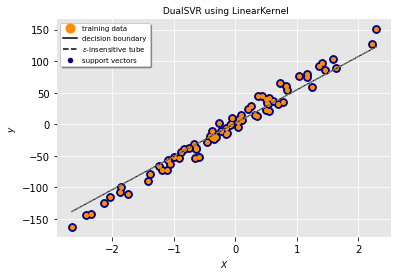

svr r2 score is 0.9548650408855112
svr found 75 support vectors from 75 examples
svr w is [52.65849015]
svr b is 1.9363056000269785


In [16]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=AdaGrad, use_explicit_eq=False, 
              nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

### Nonlinear Support Vector Machines

When applying our SVM to linearly separable data we have started by creating a matrix $Q$ from the dot product of our input variables:

$$ Q_{ij}=y_i y_j k(x_i,x_j)$$

where $k(x_i,x_j)$ is an example of a family of functions called *kernel functions* and:  

$$k(x_i,x_j)=\langle x_i, x_j \rangle=\phi(x_i)^T \phi(x_j)$$ 

is known as *linear* kernel.

The reason that this *kernel trick* is useful is that there are many classification/regression problems that are not linearly separable/regressable in the space of the inputs $x$, which might be in a higher dimensionality feature space given a suitable mapping $x \rightarrow \phi(x)$.

### Polynomial Kernel

The *polynomial* kernel is defined as:

$$k(x_i,x_j)=(\gamma \langle x_i, x_j\rangle + r)^d$$

where $\gamma$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*, $d$ by *degree* and $r$ by *coef0*.

#### Support Vector Classifier

In [40]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-3.8915e-02
   5	-7.4285e-02
  10	-8.0784e-02
  15	-8.0797e-02
  20	-8.0804e-02
  25	-8.0865e-02
  30	-8.0879e-02
  35	-8.0889e-02
  40	-8.0894e-02
  45	-8.0896e-02
  50	-8.0897e-02
  55	-8.0897e-02

CPU times: user 1.37 s, sys: 1.09 s, total: 2.46 s
Wall time: 479 ms


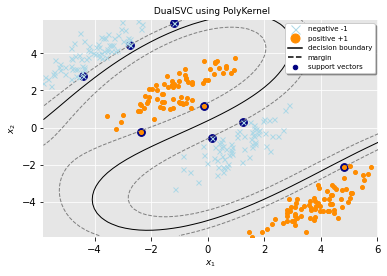

svc accuracy score is 0.99
svc found 8 support vectors from 300 examples
svc b is -0.39090409395469894

     pcost       dcost       gap    pres   dres
 0: -3.4122e+02 -3.3938e+04  1e+05  1e+00  9e-11
 1: -1.7325e+02 -1.4503e+04  3e+04  2e-01  6e-11
 2: -4.1036e+01 -3.3642e+03  6e+03  5e-02  3e-11
 3: -8.2065e+00 -1.0808e+03  2e+03  1e-02  1e-11
 4:  5.0085e+00 -6.9186e+01  1e+02  7e-04  3e-12
 5:  3.4128e+00 -2.8036e+01  4e+01  2e-04  9e-13
 6:  1.1145e+00 -5.1984e+00  7e+00  2e-05  1e-13
 7:  1.5933e-01 -3.5861e-01  5e-01  2e-07  8e-15
 8:  1.2324e-02 -1.2559e-01  1e-01  5e-08  5e-15
 9: -2.5892e-02 -1.2117e-01  1e-01  2e-08  3e-15
10: -5.4092e-02 -1.1421e-01  6e-02  6e-09  3e-15
11: -5.8025e-02 -1.1183e-01  5e-02  4e-09  3e-15
12: -7.7191e-02 -8.5496e-02  8e-03  2e-10  4e-15
13: -7.7789e-02 -8.5026e-02  7e-03  1e-10  3e-15
14: -8.0372e-02 -8.1558e-02  1e-03  1e-11  3e-15
15: -8.0878e-02 -8.0920e-02  4e-05  2e-13  4e-15
16: -8.0897e-02 -8.0897e-02  5e-07  3e-15  4e-15
17: -8.0897e-02

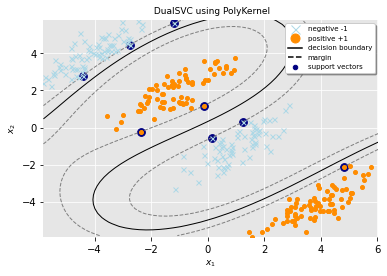

cvxopt svc accuracy score is 0.98
cvxopt svc found 8 support vectors from 300 examples
cvxopt svc b is -0.3467706042660512

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.79 ms


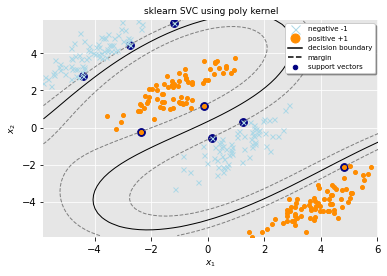

sklearn svc accuracy score is 0.98
sklearn svc found 8 support vectors from 300 examples
sklearn svc b is [-0.34684554]


In [41]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, optimizer=SMOClassifier, verbose=5)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, optimizer='cvxopt', verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
print(f'cvxopt svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SklSVC(kernel='poly', degree=3, coef0=3, gamma='auto', C=1)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.24) is:

In [17]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	 9.7491e+13	pcost:  9.4272e+08	gap: -1.0341e+05	itn: 146	rnorm: 8.0795e+14

CPU times: user 397 ms, sys: 338 ms, total: 735 ms
Wall time: 111 ms


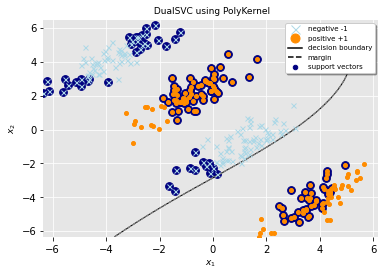

svc accuracy score is 0.78
svc found 147 support vectors from 300 examples
svc b is -282964.10226509895


In [18]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, optimizer=AdaGrad, 
              use_explicit_eq=True, nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.30) is:

epoch	iter	 cost	
   0	   0	 3.9128e+02	pcost:  1.3504e+06	gap:  9.9971e-01	itn: 145	rnorm: 2.2702e+07
   1	   1	 5.3640e+09	pcost:  1.3504e+06	gap: -3.9711e+03	itn: 144	rnorm: 2.7453e+13

CPU times: user 1.14 s, sys: 1.04 s, total: 2.18 s
Wall time: 330 ms


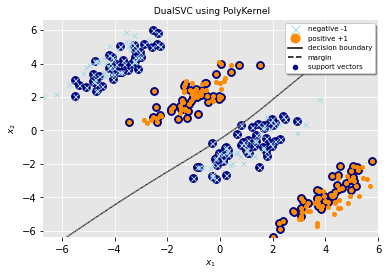

svc accuracy score is 0.5
svc found 190 support vectors from 300 examples
svc b is -436.56333470409675


In [19]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, optimizer=AdaGrad, 
              use_explicit_eq=False, nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

#### Support Vector Regression

In [46]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import train_test_split

CPU times: user 28min 51s, sys: 179 ms, total: 28min 51s
Wall time: 28min 51s


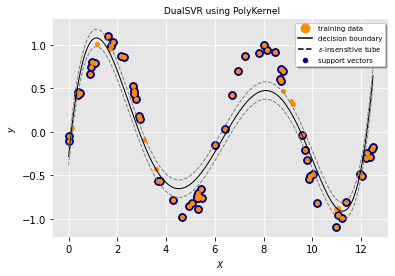

svr r2 score is 0.8866781000272429
svr found 65 support vectors from 75 examples
svr b is -0.2984941354199902

     pcost       dcost       gap    pres   dres
 0: -2.6829e+00 -1.9707e+02  2e+02  3e-17  4e-10
 1: -5.4548e+00 -2.5355e+01  2e+01  1e-16  4e-10
 2: -1.1473e+01 -1.6126e+01  5e+00  2e-16  4e-10
 3: -1.2899e+01 -1.4323e+01  1e+00  2e-16  4e-10
 4: -1.3431e+01 -1.3735e+01  3e-01  2e-16  3e-10
 5: -1.3518e+01 -1.3623e+01  1e-01  2e-16  3e-10
 6: -1.3560e+01 -1.3574e+01  1e-02  2e-16  4e-10
 7: -1.3566e+01 -1.3567e+01  7e-04  1e-16  4e-10
 8: -1.3567e+01 -1.3567e+01  7e-06  2e-16  4e-10
Optimal solution found.

CPU times: user 68.9 ms, sys: 52 ms, total: 121 ms
Wall time: 19.2 ms


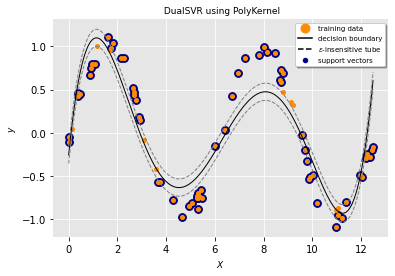

cvxopt svr r2 score is 0.8831486000403188
cvxopt svr found 65 support vectors from 75 examples
cvxopt svr b is 0.025836426934174643

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


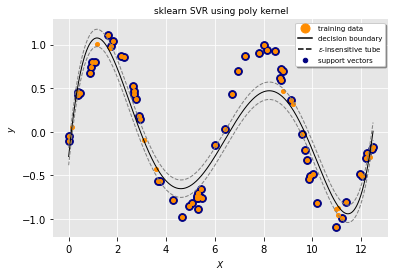

sklearn svr r2 score is 0.8817037899796948
sklearn svr found 64 support vectors from 75 examples
sklearn svr b is [-0.29943022]


In [7]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), 
              epsilon=0.1, C=10, optimizer=SMORegression, verbose=False)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), 
              epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='poly', degree=5, coef0=4, gamma='scale', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.24) is:

In [20]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-4.3833e+00	pcost: -2.6136e+00	gap:  6.7712e-01	itn:  11	rnorm: 3.1746e+00
   1	   1	-3.7410e+00	pcost: -2.6136e+00	gap:  4.3135e-01	itn:  11	rnorm: 2.9246e+00
   2	   2	-3.3326e+00	pcost: -2.6136e+00	gap:  2.7510e-01	itn:  11	rnorm: 2.8264e+00
   3	   3	-3.0244e+00	pcost: -2.6136e+00	gap:  1.5719e-01	itn:  11	rnorm: 2.7962e+00
   4	   4	-2.7748e+00	pcost: -2.6136e+00	gap:  6.1701e-02	itn:  11	rnorm: 2.8056e+00
   5	   5	-2.5646e+00	pcost: -2.6136e+00	gap: -1.8736e-02	itn:  11	rnorm: 2.8402e+00

CPU times: user 88.7 ms, sys: 107 ms, total: 196 ms
Wall time: 30.1 ms


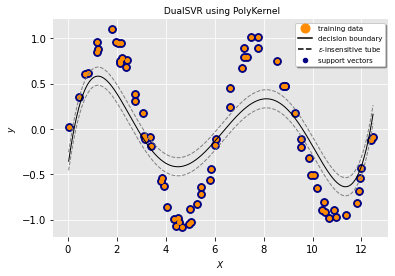

svr r2 score is 0.629720852060883
svr found 75 support vectors from 75 examples
svr b is -0.028556055244203543


In [21]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              use_explicit_eq=True, nonposdef_solver='lsqr', nonposdef_solver_verbose=False, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.30) is:

epoch	iter	 cost	
   0	   0	-6.5583e+00	pcost: -3.8256e+00	gap:  7.1432e-01	itn:  11	rnorm: 2.5190e+00
   1	   1	-5.5146e+00	pcost: -3.8256e+00	gap:  4.4149e-01	itn:  11	rnorm: 2.2185e+00
   2	   2	-4.8595e+00	pcost: -3.8256e+00	gap:  2.7026e-01	itn:  11	rnorm: 2.1056e+00
   3	   3	-4.3695e+00	pcost: -3.8256e+00	gap:  1.4217e-01	itn:  11	rnorm: 2.0792e+00
   4	   4	-3.9755e+00	pcost: -3.8256e+00	gap:  3.9183e-02	itn:  11	rnorm: 2.1027e+00
   5	   5	-3.6458e+00	pcost: -3.8256e+00	gap: -4.7001e-02	itn:  14	rnorm: 2.1569e+00

CPU times: user 89.7 ms, sys: 64.2 ms, total: 154 ms
Wall time: 28.6 ms


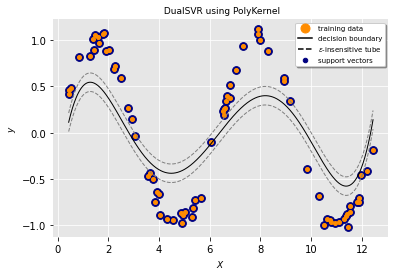

svr r2 score is 0.6282404185972243
svr found 75 support vectors from 75 examples
svr b is -0.0318765086837575


In [22]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              use_explicit_eq=False, nonposdef_solver='lsqr', nonposdef_solver_verbose=False, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

### Gaussian RBF Kernel

The *gaussian* kernel is defined as:

$$k(x_i,x_j)=\exp(-\frac{\|x_i-x_j\|^2}{2\sigma^2})$$

or, equivalently, as:

$$k(x_i,x_j)=\exp(-\gamma \|x_i-x_j\|^2)$$

where $\displaystyle \gamma=\frac{1}{2\sigma^2}$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*.

#### Support Vector Classifier

In [50]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-8.9667e+00
   2	-1.0346e+01
   4	-1.0408e+01
   6	-1.0412e+01
   8	-1.0412e+01
  10	-1.0417e+01
  12	-1.0417e+01

CPU times: user 1.95 s, sys: 1.42 s, total: 3.38 s
Wall time: 749 ms


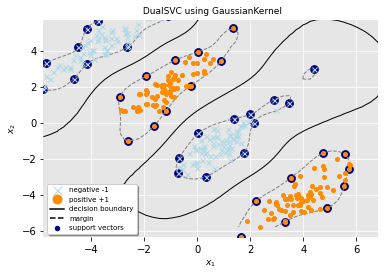

svc accuracy score is 1.0
svc found 41 support vectors from 300 examples
svc b is 0.016687303831847404

     pcost       dcost       gap    pres   dres
 0:  4.7378e+02 -5.5695e+03  1e+04  2e-01  2e-15
 1:  2.6328e+02 -6.3289e+02  1e+03  9e-03  2e-15
 2:  3.1252e+01 -8.8851e+01  1e+02  2e-16  3e-15
 3: -5.4026e+00 -2.1162e+01  2e+01  4e-16  1e-15
 4: -8.5926e+00 -1.2288e+01  4e+00  6e-16  4e-16
 5: -9.6730e+00 -1.1465e+01  2e+00  2e-16  2e-16
 6: -1.0155e+01 -1.0809e+01  7e-01  1e-15  2e-16
 7: -1.0358e+01 -1.0514e+01  2e-01  2e-16  2e-16
 8: -1.0404e+01 -1.0438e+01  3e-02  7e-16  2e-16
 9: -1.0417e+01 -1.0418e+01  8e-04  5e-16  2e-16
10: -1.0417e+01 -1.0417e+01  8e-06  3e-16  3e-16
Optimal solution found.

CPU times: user 251 ms, sys: 134 ms, total: 385 ms
Wall time: 66.4 ms


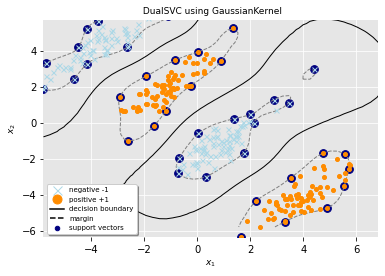

cvxopt svc accuracy score is 1.0
cvxopt svc found 41 support vectors from 300 examples
cvxopt svc b is 0.016232560006575712

CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 1.81 ms


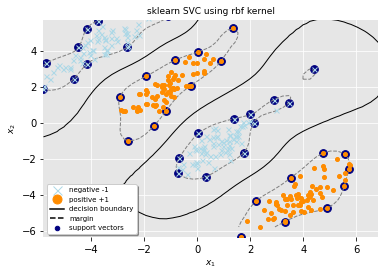

sklearn svc accuracy score is 1.0
sklearn svc found 41 support vectors from 300 examples
sklearn svc b is [0.01622188]


In [51]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer=SMOClassifier, verbose=2)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer='cvxopt', verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
print(f'cvxopt svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SklSVC(kernel='rbf', gamma='auto', C=1)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.24) is:

In [9]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-2.1608e+06	pcost:  9.5747e+04	gap:  2.3568e+01
 100	 100	-6.3440e+09	pcost:  9.4942e+04	gap:  6.6821e+04
 200	 200	-8.9946e+08	pcost:  9.4942e+04	gap:  9.4748e+03
 300	 300	-3.5516e+08	pcost:  8.8124e+04	gap:  4.0312e+03
 400	 400	-2.0809e+08	pcost:  8.8124e+04	gap:  2.3623e+03
 500	 500	-1.2304e+08	pcost:  8.8124e+04	gap:  1.3972e+03
 600	 600	-7.3479e+07	pcost:  8.8124e+04	gap:  8.3482e+02
 700	 700	-6.7768e+07	pcost:  8.8124e+04	gap:  7.7000e+02
 800	 800	-3.9663e+07	pcost:  8.8124e+04	gap:  4.5108e+02
 900	 900	-3.0150e+07	pcost:  8.8124e+04	gap:  3.4313e+02

CPU times: user 24.3 s, sys: 12.7 s, total: 36.9 s
Wall time: 4.92 s


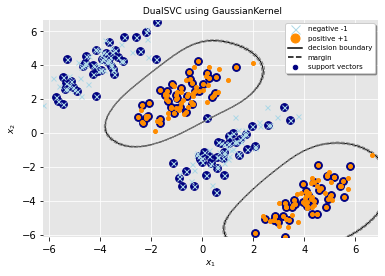

svc accuracy score is 1.0
svc found 141 support vectors from 300 examples
svc b is -11.003027467072997


In [14]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer=AdaGrad, use_explicit_eq=True, 
                  nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=100)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.30) is:

epoch	iter	 cost	
   0	   0	-4.3705e+04	pcost:  1.0373e+05	gap:  1.4213e+00
 100	 100	-5.7028e+10	pcost:  9.5833e+04	gap:  5.9508e+05
 200	 200	-5.5760e+09	pcost:  9.5833e+04	gap:  5.8185e+04
 300	 300	-6.1144e+08	pcost:  9.5833e+04	gap:  6.3813e+03
 400	 400	-5.5053e+08	pcost:  9.3572e+04	gap:  5.8845e+03
 500	 500	-8.9616e+09	pcost:  9.0612e+04	gap:  9.8901e+04
 600	 600	-1.5484e+08	pcost:  9.0612e+04	gap:  1.7098e+03
 700	 700	-1.1844e+08	pcost:  8.5803e+04	gap:  1.3814e+03
 800	 800	-8.5071e+07	pcost:  8.5803e+04	gap:  9.9247e+02
 900	 900	-6.5965e+07	pcost:  8.5803e+04	gap:  7.6980e+02

CPU times: user 28.9 s, sys: 12.7 s, total: 41.7 s
Wall time: 5.75 s


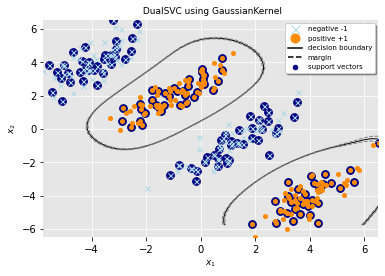

svc accuracy score is 1.0
svc found 136 support vectors from 300 examples
svc b is -11.379551770043697


In [16]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer=AdaGrad, use_explicit_eq=False, 
              nonposdef_solver='cg', nonposdef_solver_verbose=False, verbose=100)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

#### Support Vector Regression

In [ ]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.9380e+00
   5	-2.1595e+00
  10	-2.1678e+00
  15	-2.1770e+00
  20	-2.1815e+00
  25	-2.1845e+00
  30	-2.1848e+00
  35	-2.2273e+00
  40	-2.2347e+00
  45	-2.2382e+00
  50	-2.2427e+00
  55	-2.2449e+00

CPU times: user 1.21 s, sys: 1.23 s, total: 2.44 s
Wall time: 372 ms


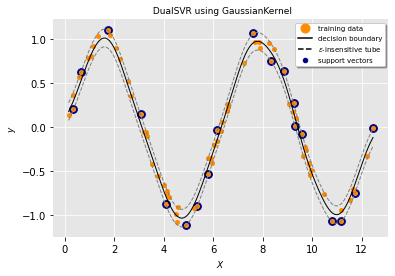

svr r2 score is 0.9818438800724006
svr found 19 support vectors from 75 examples
svr b is -0.00350379715477003

     pcost       dcost       gap    pres   dres
 0:  7.1674e+01 -1.6923e+03  2e+03  2e-15  1e-14
 1:  6.3454e+01 -8.6894e+01  2e+02  2e-14  1e-14
 2:  9.8863e+00 -1.3805e+01  2e+01  1e-14  1e-14
 3:  9.3548e-01 -5.0482e+00  6e+00  4e-15  4e-15
 4: -1.6500e+00 -2.9191e+00  1e+00  6e-15  2e-15
 5: -2.1287e+00 -2.3743e+00  2e-01  5e-15  2e-15
 6: -2.2302e+00 -2.2645e+00  3e-02  2e-15  2e-15
 7: -2.2436e+00 -2.2477e+00  4e-03  3e-15  2e-15
 8: -2.2454e+00 -2.2455e+00  7e-05  3e-16  2e-15
 9: -2.2454e+00 -2.2454e+00  7e-07  1e-15  2e-15
Optimal solution found.

CPU times: user 107 ms, sys: 104 ms, total: 211 ms
Wall time: 33.6 ms


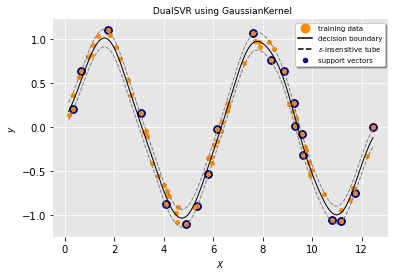

cvxopt svr r2 score is 0.9818956752270985
cvxopt svr found 20 support vectors from 75 examples
cvxopt svr b is -0.007759060829779911

CPU times: user 912 µs, sys: 431 µs, total: 1.34 ms
Wall time: 790 µs


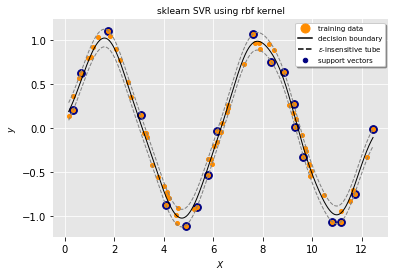

sklearn svr r2 score is 0.9820191972919681
sklearn svr found 19 support vectors from 75 examples
sklearn svr b is [0.00682271]


In [57]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer=SMORegression, verbose=5)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='rbf', gamma='auto', C=1)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.24) is:

In [17]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	

ConjugateGradient
iter	feval	 cost		 gnorm
   0	   1	 2.1344e+02	 5.0350e+02				ls:  1	it:  2	astar:  1.4523e-03
  20	  56	-3.5118e+01	 2.2928e+00	beta:  1.4624e-01	ls:  1	it:  2	astar:  3.5736e-03
  40	 108	-3.5193e+01	 1.8764e+00	beta:  5.5688e+00	ls:  1	it:  2	astar:  3.4113e-03
  60	 161	-3.5222e+01	 3.6973e-01	beta:  7.2950e-01	ls:  1	it:  1	astar:  1.0000e-02
  80	 211	-3.5240e+01	 1.0849e+00	beta:  3.8586e+00	ls:  1	it:  2	astar:  3.7729e-03
 100	 265	-3.5261e+01	 1.1807e-01	beta:  3.3027e-01	ls:  1	it:  1	astar:  1.0000e-02
 120	 318	-3.5262e+01	 1.7409e-01	beta:  2.8210e+00	ls:  1	it:  2	astar:  3.3757e-03
 140	 371	-3.5264e+01	 6.9196e-02	beta:  9.8840e-02	ls:  1	it:  1	astar:  1.0000e-02
 160	 425	-3.5264e+01	 4.3949e-02	beta:  2.1133e-01	ls:  1	it:  1	astar:  1.0000e-02
 180	 479	-3.5264e+01	 3.6424e-02	beta:  6.5299e-01	ls:  1	it:  1	astar:  1.4114e-02
 200	 532	-3.5265e+01	 3.5333e-02	beta:  2.5150e-01	ls:  1	it:  1	astar:  1.0000e-02
 220	 583	-3.5265e

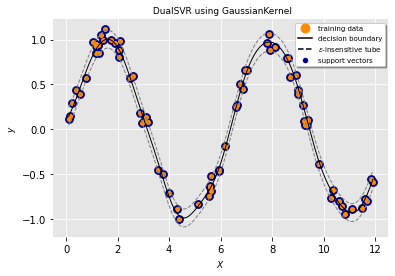

svr r2 score is 0.9908400213696281
svr found 75 support vectors from 75 examples
svr b is -0.015232631685960386


In [18]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              use_explicit_eq=True, nonposdef_solver='cg', nonposdef_solver_verbose=20, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

The solution of the *Lagrangian dual* relaxation according to (1.30) is:

epoch	iter	 cost	

ConjugateGradient
iter	feval	 cost		 gnorm
   0	   1	 8.5827e+02	 6.5004e+03				ls:  1	it:  3	astar:  3.3943e-05
  20	  63	-3.1896e+01	 2.9528e+01	beta:  7.8330e+00	ls:  1	it:  2	astar:  1.0000e-04
  40	 125	-3.2022e+01	 7.9230e+00	beta:  1.8396e+00	ls:  1	it:  2	astar:  1.2586e-04
  60	 185	-3.2070e+01	 4.7769e+00	beta:  1.2566e+00	ls:  1	it:  2	astar:  1.1102e-04
  80	 245	-3.2117e+01	 7.7248e+00	beta:  1.3389e+00	ls:  1	it:  2	astar:  1.2457e-04
 100	 305	-3.2166e+01	 2.7546e+00	beta:  7.6216e-01	ls:  1	it:  2	astar:  1.2508e-04
 120	 365	-3.2187e+01	 4.6357e+00	beta:  8.9567e-01	ls:  1	it:  2	astar:  1.6139e-04
 140	 425	-3.2220e+01	 2.2192e+00	beta:  6.2565e-01	ls:  1	it:  2	astar:  1.5616e-04
 160	 485	-3.2229e+01	 2.7138e+00	beta:  9.5092e-01	ls:  1	it:  2	astar:  1.7937e-04
 180	 545	-3.2248e+01	 1.9502e+00	beta:  8.0079e-01	ls:  1	it:  2	astar:  1.3872e-04
 200	 605	-3.2253e+01	 1.9490e+00	beta:  1.3125e+00	ls:  1	it:  2	astar:  1.3838e-04
 220	 665	-3.2258e

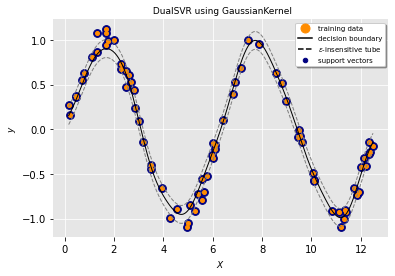

svr r2 score is 0.9688494031609044
svr found 75 support vectors from 75 examples
svr b is -0.003566196951021651


In [19]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              use_explicit_eq=False, nonposdef_solver='cg', nonposdef_solver_verbose=20, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

## Conclusions

For what about the SVM formulations, it is known, in general, that the *primal* formulation, is suitable for large linear training since the complexity of the model grows with the number of features or, more in general, when the number of examples $n$ is much larger than the number of features $m$, $n \gt\gt m$; meanwhile the *dual* formulation, is more suitable in case the number of examples $n$ is less than the number of features $m$, $n \lt m$, since the complexity of the model is dominated by the number of examples.

From all these experiments we can see that *cvxopt* underperform the *sklearn* implementation in terms of time since it is a general-purpose QP solver and it doesn't exploit the structure of the problem. In the field of numerical optimization, it is known that if you are looking for better performance you should use a better model, so ad hoc implementations able to embed the knowledge of the specific problem are welcome. 
Despite this, the *custom* implementation does not overperform the *cvxopt* probably due to the tradeoff generated from the different core implementations, Python and C respectively.
For these reasons, *sklearn* provides better results in terms of time wrt the other implementations since it is designed to work in a large-scale context and its core is implemented in C.

Important consideration involves the number of support vector machines: the *Lagrangian dual* formulation tends to select all the data points as support vectors, so it makes the model complex and unable to generalize. In fact, the scores are lower wrt the equivalent *Wolfe dual* formulation.

## References

[[1]](#ref-1) [A. Frangioni. _Standard Bundle Methods: Untrusted Models and Duality._](http://eprints.adm.unipi.it/2378/1/StandardBundle.pdf)

[[2]](#ref-2) [J.C. Platt. _Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines._](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

[[3]](#ref-3) [S.S. Keerthi, S.K. Shevade, C. Bhattacharyya, K.R.K. Murthy. _Improvements to Platt's SMO Algorithm for SVM Classifier Design._](http://web.cs.iastate.edu/~honavar/keerthi-svm.pdf)

[[4]](#ref-4) [J. Duchi, E. Hazan, Y. Singer. _Adaptive Subgradient Methods for Online Learning and Stochastic Optimization._](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

[[5]](#ref-5) [G.W. Flake, S. Lawrence. _Efficient SVM Regression Training with SMO._](https://link.springer.com/content/pdf/10.1023/A:1012474916001.pdf)

[[6]](#ref-6) [S.K. Shevade, S.S. Keerthi, C. Bhattacharyya, K.R.K. Murthy. _Improvements to SMO Algorithm for SVM Regression._](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.27.8961&rep=rep1&type=pdf)

[[7]](#ref-7) [C.W. Hsu, C.J. Lin. _A simple decomposition method for support vector machines._](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.126.4700&rep=rep1&type=pdf)

[[8]](#ref-8) [T. Fletcher. _Support Vector Machines Explained._](https://static1.squarespace.com/static/58851af9ebbd1a30e98fb283/t/58902fbae4fcb5398aeb7505/1485844411772/SVM+Explained.pdf)